# Librerías

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from eli5 import show_weights, show_prediction
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.layers import Masking

%matplotlib inline

Using TensorFlow backend.


# Datos

In [3]:
train = pd.read_csv('../data/final_train_pw.csv')
test = pd.read_csv('../data/final_test_pw.csv')

In [4]:
train.head()

,product_id,block_id,stock,std_stock,family_id,subfamily_id,size_id,color_id,position,category_id,...,N2,N3,N5,N6,N7,N8,N9,N10,N12,N13
0,310130,1726,1383,34.811328,0.007081,0.000583,7,1,3.0,3,...,13,39,10,10,6184,10,10,10,17,13
1,1178388,592,60,2.160247,0.049343,0.012578,4,1,19.0,1,...,412,756,10,10,10634,10,208,129,10,412
2,1561460,1625,2373,55.438769,0.123499,0.023558,5,1,38.0,3,...,480,1577,10,10,8208,10,1130,380,12,480
3,1874414,1135,1686,20.463906,0.110920,0.016119,6,1,12.0,6,...,445,954,10,10,5295,10,268,69,10,423
4,2436420,779,245,23.377339,0.025814,0.004422,5,1,NaN,0,...,151,296,10,10,8208,10,27,17,19,151


In [4]:
test.head()

,date_number,product_id,block_id,stock,std_stock,family_id,subfamily_id,size_id,color_id,position_max,...,N3,N5,N6,N7,N8,N9,N10,N11,N12,N13
0,71,151926,1969,636,33.103206,0.131242,0.035875,5,1,22.0,...,2198,7,7,8113,7,1169,413,59,7,615
1,71,213413,1648,1190,36.225788,0.034750,0.003149,7,1,139.0,...,196,7,7,5145,7,42,28,4,7,80
2,71,310130,1726,442,52.809180,0.008210,0.000562,7,1,46.0,...,35,7,7,5145,7,7,7,1,7,10
3,71,455200,1400,86,6.831301,0.043185,0.007647,3,1,53.0,...,287,7,7,6391,7,63,49,7,7,75
4,71,571044,1098,416,42.178063,0.103014,0.023392,4,2,205.0,...,1036,7,7,1673,7,441,98,14,7,145


In [5]:
drop_cols = ['sales', 'date_number', 'product_id', 'block_id']

X_train = train.loc[:,[c for c in train.columns if c not in drop_cols]]
y_train = train[['sales']]
X_test = test.loc[:,[c for c in train.columns if c not in drop_cols]]

Estandarización de las variables para modelos lineales y redes neuronales.

In [6]:
cols_ss = ['stock', 'std_stock', 'position', 'stock_lag1',
       'stock_lead1', 'std_stock_shift1', 'mean_stock_shift1',
       'min_stock_shift1', 'max_stock_shift1', 'median_stock_shift1',
       'stock_lag2', 'stock_lead2', 'std_stock_shift2', 'min_stock_shift2',
       'max_stock_shift2', 'median_stock_shift2', 'mean_stock_shift2',
       'pos_lag1', 'pos_lead1', 'std_pos_shift1', 'mean_pos_shift1',
       'min_pos_shift1', 'max_pos_shift1', 'median_pos_shift1', 'pos_lag2',
       'pos_lead2', 'std_pos_shift2', 'min_pos_shift2', 'max_pos_shift2',
       'median_pos_shift2', 'mean_pos_shift2', 'diff_stock_lead1',
       'diff_stock_lead2', 'diff_stock_lag1', 'diff_stock_lag2',
       'diff_pos_lead1', 'diff_pos_lead2', 'diff_pos_lag1', 'diff_pos_lag2',
       'std_stock_shift3', 'mean_stock_shift3', 'min_stock_shift3',
       'max_stock_shift3', 'median_stock_shift3', 'std_pos_shift3',
       'mean_pos_shift3', 'min_pos_shift3', 'max_pos_shift3',
       'median_pos_shift3', 'ratio_position',
       'N1', 'N2', 'N3', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N12', 'N13']

In [7]:
ss = StandardScaler()
ss.fit(X_train[cols_ss])
X_train[cols_ss] = ss.transform(X_train[cols_ss])
X_test[cols_ss] = ss.transform(X_test[cols_ss])

/home/errodringer/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [8]:
X_test.head()

,stock,std_stock,family_id,subfamily_id,size_id,color_id,position,category_id,price,stock_lag1,...,N2,N3,N5,N6,N7,N8,N9,N10,N12,N13
0,-0.232097,0.279538,0.131242,0.035875,5,1,-0.733198,2,25.95,NaN,...,-0.334701,-0.378972,-3.772139,-2.249975,-1.440403,-3.772139,0.006116,-0.065407,-1.669897,-0.218442
1,-0.015572,0.441419,0.034750,0.003149,7,1,-0.251464,2,19.95,NaN,...,-0.752467,-0.988306,-3.772139,-2.249975,-1.566137,-3.772139,-0.696751,-0.677841,-1.669897,-0.763263
2,-0.182891,0.839566,0.008210,0.000562,7,1,-0.353369,1,12.95,NaN,...,-0.825474,-1.037309,-3.772139,-2.249975,-1.566137,-3.772139,-0.718579,-0.711247,-1.669897,-0.834548
3,-0.433461,-0.552137,0.043185,0.007647,3,1,-0.288520,2,29.95,NaN,...,-0.760579,-0.960609,-3.772139,-2.249975,-1.513352,-3.772139,-0.683654,-0.644436,-1.669897,-0.768355
4,-0.306996,0.572720,0.103014,0.023392,4,2,0.647156,2,15.95,NaN,...,-0.691627,-0.732642,-3.772139,-2.249975,-1.713222,-3.772139,-0.447910,-0.566490,-1.669897,-0.697070


In [9]:
train_ids = X_train.index
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Matrix de correlación

In [44]:
# corr = X_train.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)

# Selección de variables

In [39]:
# from sklearn.ensemble import RandomForestClassifier

In [40]:
# X_train_sample = X_train.fillna(-1).sample(frac=0.1)
# X_fit, X_val, y_fit, y_val = train_test_split(X_train_sample,
#                                               y_train.iloc[X_train_sample.index.values],
#                                               test_size=0.25,
#                                               random_state=42)

In [41]:
# params = {
#     'n_estimators': 500,
#     'criterion': 'entropy',
#     'max_depth': 10,
#     'random_state': 42,
#     'n_jobs': 8,
#     'verbose': 0,
#     'min_samples_leaf': 2,
    
# }

# rf = RandomForestClassifier(**params)

In [42]:
# rf_refit = rf.fit(X_fit, y_fit)

In [43]:
# perm = PermutationImportance(rf_refit).fit(X_val, y_val)
# show_weights(perm, feature_names=X_val.columns.tolist(), top=X_val.shape[1])

In [19]:
# X = X.fillna(-1)

# LightGBM

In [9]:
model_name = 'lgbm'

params = {'max_depth':7,
          'metric':'mae',
          'max_delta_step': 0.2,
          'n_estimators':50000,
          'learning_rate':0.1,
          'colsample_bytree':0.6,
          'objective':'regression',
          'n_jobs':8,
          'seed':42,
          'lambda_l1':0,
          'lambda_l2':0,
#           'max_bin': 14,
#           'bagging_fraction':0.8,
         }

lgb_model = lgb.LGBMRegressor(**params)

In [10]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    lgb_model.fit(X_fit,
                  y_fit,
                  eval_set=[(X_val, y_val)],
                  verbose=1000,
                  early_stopping_rounds=50)

    ft_importances += lgb_model.feature_importances_

    be += np.expm1(lgb_model.best_score_['valid_0']['l1'])
    y_preds = np.expm1(lgb_model.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]
    
    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

pr = pd.DataFrame({'predicciones_lightgbm_pw': full_preds})
pr.to_csv('../predictions/preds_lightgbm_pw.csv')

print('IMPORTANCIA DE LAS VARIABLES:\n')
imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
df_imp_sort = imp.sort_values('importance', ascending=False)
df_imp_sort

--- Fold k 1:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.459195
[2000]	valid_0's l1: 0.450289
Early stopping, best iteration is:
[2049]	valid_0's l1: 0.450113
--- Fold k 2:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.455623
[2000]	valid_0's l1: 0.444586
Early stopping, best iteration is:
[2534]	valid_0's l1: 0.441586
--- Fold k 3:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.464977
[2000]	valid_0's l1: 0.454338
Early stopping, best iteration is:
[2920]	valid_0's l1: 0.450841
--- Fold k 4:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.466662
[2000]	valid_0's l1: 0.453884
Early stopping, best iteration is:
[2480]	valid_0's l1: 0.451058
--- Fold k 5:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.459266
[2000]	valid_0's l1: 0.447861
Early stopping, best iteration is:
[2633]	valid_0's l1: 0.44

,feature,importance
1,std_stock,2797.6
37,diff_stock_lead1,2550.4
38,diff_stock_lead2,2320.8
39,diff_stock_lag1,2069.6
17,stock_lead2,1796.6
65,N9,1794.0
11,std_stock_shift1,1769.6
18,std_stock_shift2,1739.6
40,diff_stock_lag2,1619.6
66,N10,1573.8


# XGBoost

In [12]:
params = {'max_depth': 7,
          'metric':'mae',
          'n_estimators': 5000,
          'eta': 0.1,
          'colsample_bytree':0.6,
          'nthread':8,
          'seed':42,
          'objective':'reg:linear',
#           'update':'refresh',
#           'process_type': 'update',
#           'refresh_leaf': True,
         }

xgb_model = xgb.XGBRegressor(**params)

In [13]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    xgb_model.fit(X_fit,
                  y_fit,
                  eval_set=[(X_val, y_val)],
                  verbose=100,
                  early_stopping_rounds=10,
                  eval_metric='mae')

    ft_importances += xgb_model.feature_importances_

    be += np.expm1(xgb_model.best_score)
    y_preds = np.expm1(xgb_model.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]

    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

# pr = pd.DataFrame({'predicciones_xgboost_pw': full_preds})
# pr.to_csv('../predictions/preds_xgboost_pw.csv')

print('IMPORTANCIA DE LAS VARIABLES:\n')
imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
df_imp_sort = imp.sort_values('importance', ascending=False)
df_imp_sort

--- Fold k 1:


XGBoostError: b'[20:15:16] /workspace/src/gbm/gbtree.cc:290: Check failed: model_.trees.size() < model_.trees_to_update.size() (0 vs. 0) \n\nStack trace returned 10 entries:\n[bt] (0) /home/errodringer/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::StackTrace()+0x3d) [0x7f04e27b45cd]\n[bt] (1) /home/errodringer/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x18) [0x7f04e27b49c8]\n[bt] (2) /home/errodringer/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::gbm::GBTree::BoostNewTrees(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::DMatrix*, int, std::vector<std::unique_ptr<xgboost::RegTree, std::default_delete<xgboost::RegTree> >, std::allocator<std::unique_ptr<xgboost::RegTree, std::default_delete<xgboost::RegTree> > > >*)+0x8f6) [0x7f04e28870a6]\n[bt] (3) /home/errodringer/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::gbm::GBTree::DoBoost(xgboost::DMatrix*, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::ObjFunction*)+0x90e) [0x7f04e2887b1e]\n[bt] (4) /home/errodringer/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x3b8) [0x7f04e282b238]\n[bt] (5) /home/errodringer/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x35) [0x7f04e27acab5]\n[bt] (6) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f052d148dae]\n[bt] (7) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7f052d14871f]\n[bt] (8) /usr/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2b4) [0x7f052d35c524]\n[bt] (9) /usr/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x11b93) [0x7f052d35cb93]\n\n'

# CatBoost

In [13]:
params = {
    'depth':7,
    'iterations':5000,
    'eval_metric':'MAE',
    'random_seed':42,
    'early_stopping_rounds':[5],
    'learning_rate':0.1,
    'thread_count':8,
    'boosting_type':'Plain',
    'bootstrap_type':'Bernoulli',
    'colsample_bylevel':0.6
}

model_cb = CatBoostRegressor(**params)

In [14]:
# cat_ft = ['day']

# cat_ft_id = list()
# n = 0
# for c in X_train.columns:
#     if c in cat_ft:
#         cat_ft_id.append(n)
#     n += 1

In [16]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    model_cb.fit(X_fit,
                 y_fit,
                 eval_set=[(X_val, y_val)],
                 verbose=200,
#                  cat_features=cat_ft_id,
                 early_stopping_rounds=10)

    ft_importances += model_cb.feature_importances_

    be += np.expm1(model_cb.best_score_['validation_0']['MAE'])
    y_preds = np.expm1(model_cb.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]

    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

pr = pd.DataFrame({'predicciones_catboost_pw': full_preds})
pr.to_csv('../predictions/preds_catboost_pw.csv')

print('IMPORTANCIA DE LAS VARIABLES:\n')
imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
df_imp_sort = imp.sort_values('importance', ascending=False)
df_imp_sort

--- Fold k 1:
0:	learn: 2.7921344	test: 2.8562083	best: 2.8562083 (0)	total: 10.6ms	remaining: 52.8s
200:	learn: 0.4915638	test: 0.5117891	best: 0.5117891 (200)	total: 1.9s	remaining: 45.5s
400:	learn: 0.4474824	test: 0.4858574	best: 0.4858574 (400)	total: 3.99s	remaining: 45.7s
600:	learn: 0.4193512	test: 0.4731370	best: 0.4731370 (600)	total: 5.81s	remaining: 42.5s
800:	learn: 0.3973675	test: 0.4657925	best: 0.4657925 (800)	total: 7.62s	remaining: 40s
1000:	learn: 0.3783311	test: 0.4597350	best: 0.4597350 (1000)	total: 9.51s	remaining: 38s
1200:	learn: 0.3619541	test: 0.4557549	best: 0.4557549 (1200)	total: 11.6s	remaining: 36.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4534729825
bestIteration = 1358

Shrink model to first 1359 iterations.
--- Fold k 2:
0:	learn: 2.8202971	test: 2.7346086	best: 2.7346086 (0)	total: 9.42ms	remaining: 47.1s
200:	learn: 0.4932372	test: 0.5076623	best: 0.5076623 (200)	total: 2.22s	remaining: 53s
400:	learn: 0.4493619	test: 0.4

,feature,importance
7,category_id,7.522169
11,std_stock_shift1,5.721651
46,mean_stock_shift3,5.687084
37,diff_stock_lead1,5.480231
1,std_stock,4.794732
18,std_stock_shift2,4.735298
0,stock,4.418439
6,position,3.246536
49,median_stock_shift3,2.431827
39,diff_stock_lag1,2.245342


# Keras

In [54]:
X_train_sample = X_train.fillna(-1)#.sample(frac=0.1)
X_fit, X_val, y_fit, y_val = train_test_split(X_train_sample,
                                              y_train.iloc[X_train_sample.index.values],
                                              test_size=0.25,
                                              random_state=42)

y_val = np.log1p(y_val)
y_fit = np.log1p(y_fit)

In [125]:
callbacks = [EarlyStopping(monitor='val_loss',
                           min_delta=0.0,
                           patience=3,
                           verbose=1,
                           mode='min',
                           restore_best_weights=True)]

In [126]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, kernel_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Masking(mask_value=-1))
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [127]:
estimator = KerasRegressor(build_fn=create_baseline,
                           epochs=100,
                           batch_size=1024,
                           verbose=1,
                           callbacks=callbacks,
                           validation_data=(X_val, y_val))

In [128]:
model = create_baseline()

In [129]:
history = estimator.fit(X_fit, y_fit)

Train on 53986 samples, validate on 12954 samples
Epoch 1/100
53986/53986 [==============================] - 3s 57us/step - loss: 71.5701 - val_loss: 40.5570
Epoch 2/100
53986/53986 [==============================] - 2s 41us/step - loss: 56.9466 - val_loss: 39.2343
Epoch 3/100
53986/53986 [==============================] - 2s 41us/step - loss: 54.9822 - val_loss: 39.2244
Epoch 4/100
53986/53986 [==============================] - 2s 42us/step - loss: 53.6224 - val_loss: 38.5947
Epoch 5/100
53986/53986 [==============================] - 2s 42us/step - loss: 51.8336 - val_loss: 35.3132
Epoch 6/100
53986/53986 [==============================] - 2s 41us/step - loss: 50.3344 - val_loss: 35.2626
Epoch 7/100
53986/53986 [==============================] - 2s 42us/step - loss: 49.2566 - val_loss: 33.7970
Epoch 8/100
53986/53986 [==============================] - 2s 42us/step - loss: 49.0929 - val_loss: 35.3010
Epoch 9/100
53986/53986 [==============================] - 2s 43us/step - loss: 47.899

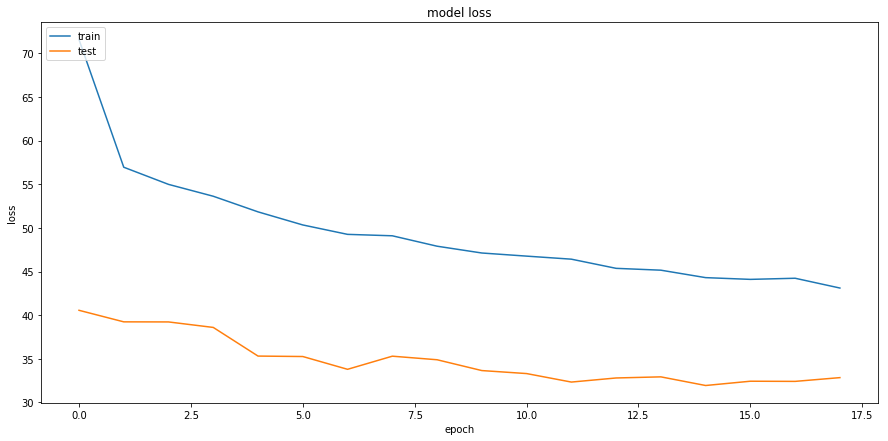

In [130]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [131]:
keras_preds = estimator.predict(X_test.fillna(-1))

8892/8892 [==============================] - 0s 42us/step


In [132]:
np.expm1(keras_preds)[:20]

array([2.6985578e+22, 6.4428597e+23, 8.6390270e+11, 8.6514801e+01,
       2.7918719e+26,           inf,           inf, 8.3036050e-02,
       1.2666060e+06, 8.2322948e+34, 4.8008733e+00, 4.0634163e+09,
       1.2145674e+02, 1.6532171e+00,           inf, 2.4927830e+32,
       2.1460220e+25, 1.0394682e+07, 2.5452344e+05, 3.0771423e+24],
      dtype=float32)

In [104]:
from sklearn.linear_model import Lasso, Ridge

In [133]:
lasso = Lasso()
ridge = Ridge(alpha=100,
              fit_intercept=True,
              normalize=False,
              copy_X=True,
              max_iter=1e6,
              tol=0.01,
              random_state=42)

In [134]:
counter = 1
be = 0
for train_index, test_index in skf.split(train_ids, y_train):
    print('Fold k {}\n'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_fit = X_fit.fillna(-1)
    X_val = X_val.fillna(-1)
    
#     y_val = np.log1p(y_val)
#     y_fit = np.log1p(y_fit)
    
    ridge.fit(X_fit, y_fit)
    
    print('Score en el test:',mean_absolute_error(ridge.predict(X_val), y_val),'ventas')
#     print('Score en el test:',mean_absolute_error(np.expm1(lasso.predict(X_test.fillna(-1))), y_test),'ventas')
    
    counter += 1
    
    
# print('\n\nBEST SCORE MEAN:', be / k,'SALES :)')

Fold k 1

Score en el test: 64.88086937583938 ventas
Fold k 2

Score en el test: 54.13480765738701 ventas
Fold k 3

Score en el test: 57.697222867256 ventas
Fold k 4

Score en el test: 95.66856823488475 ventas
Fold k 5

Score en el test: 54.505076034070875 ventas


In [136]:
from sklearn.model_selection import TimeSeriesSplit

In [143]:
tscv = TimeSeriesSplit(n_splits=63)

In [144]:
counter = 1
be = 0
for train_index, test_index in tscv.split(X_train):
    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_fit = X_fit.fillna(-1)
    X_val = X_val.fillna(-1)
    
#     y_val = np.log1p(y_val)
#     y_fit = np.log1p(y_fit)
    
    
    ridge.fit(X_fit,
                  y_fit,
#                   eval_set=[(X_val, y_val)],
#                   verbose=1000,
#                   early_stopping_rounds=20
             )
    
    print('Score en el test:',mean_absolute_error(ridge.predict(X_val), y_val),'ventas')

#     be += np.expm1(lgb_model.best_score_['valid_0']['l1'])
#     be += lgb_model.best_score_['valid_0']['l1']
    
#     print('Score en el test:',mean_absolute_error(lgb_model.predict(X_test), y_test),'ventas')
#     print('Score en el test:',mean_absolute_error(np.expm1(lgb_model.predict(X_test)), y_test),'ventas')
    
    counter += 1

Score en el test: 14.756823797072453 ventas
Score en el test: 14.100715922865659 ventas
Score en el test: 12.151307647028101 ventas
Score en el test: 51.86876752206717 ventas
Score en el test: 71.48256121213558 ventas
Score en el test: 71.92217457062922 ventas
Score en el test: 68.28141522284636 ventas
Score en el test: 70.27419173579888 ventas
Score en el test: 68.17364411398036 ventas
Score en el test: 68.03255886397835 ventas
Score en el test: 67.67764600238846 ventas
Score en el test: 67.92744267608478 ventas
Score en el test: 60.29241413900714 ventas
Score en el test: 73.54090753222067 ventas
Score en el test: 98.75496060857435 ventas
Score en el test: 101.1358736415784 ventas
Score en el test: 94.34493406037016 ventas
Score en el test: 89.109853582185 ventas
Score en el test: 94.87292021432982 ventas
Score en el test: 101.50598193500386 ventas
Score en el test: 83.5619960969 ventas
Score en el test: 82.39001244804034 ventas
Score en el test: 79.99393026544735 ventas
Score en el t